In [1]:
import matplotlib.pyplot as plt
import numpy as np
import csv

In [2]:
# These variables can be modified by the user.

# Path to data csv file
DATA_FILENAME = "data/test_data.csv"

# Indicate what values are in each column.
# The current default:
# - column 0 is assumed to hold values of parameter 1
# - column 1 is assumed to hold values of parameter 2
# - column 2 is assumed to hold performance values
PAR1_COL = 0
PAR2_COL = 1
PERF_COL = 2

# Indicate what data types should be used for each parameter and the performance measure
PAR1_TYPE = np.int
PAR2_TYPE = np.int
PERF_TYPE = np.float

# Indicate whether to plot by decreasing order for each parameter.
# If False, then results will be plotted in increasing order.
SORT_PAR1_DECREASING = True
SORT_PAR2_DECREASING = True

In [3]:
# Load and sort data from specified data file.

par1 = np.array([])
par2 = np.array([])
perf = np.array([])

with open(DATA_FILENAME, 'r') as file:
    csvreader = csv.reader(file)
    
    # Assuming field names are the first row of data file:
    fields = np.array(next(csvreader))
    
    for row in csvreader:
        par1 = np.append(par1, row[PAR1_COL])
        par2 = np.append(par2, row[PAR2_COL])
        perf = np.append(perf, row[PERF_COL])
            
par1 = par1.astype(PAR1_TYPE)
par2 = par2.astype(PAR2_TYPE)
perf = perf.astype(PERF_TYPE)
num_vals = np.size(perf)

# Sort by parameter 1.
par1_sorted_ind = np.argsort(par1)
if SORT_PAR1_DECREASING:
    par1_sorted_ind = par1_sorted_ind[::-1]
par1 = par1[par1_sorted_ind]
par2 = par2[par1_sorted_ind]
perf = perf[par1_sorted_ind]

# Sort by parameter 2, maintaining sorted order of parameter 1.
par2_sorted_ind = np.array([])
start_ind = 0
unique_par1 = np.sort(np.unique(par1))
if SORT_PAR1_DECREASING:
    unique_par1 = unique_par1[::-1]
for par1val in unique_par1:
    par2_slice = par2[np.where(par1 == par1val)[0]]
    par2_slice_sorted_ind = np.argsort(par2_slice)
    if SORT_PAR2_DECREASING:
        par2_slice_sorted_ind[::-1]
    par2_sorted_ind = np.append(par2_sorted_ind, par2_slice_sorted_ind + start_ind)
    start_ind = start_ind + np.size(par2_slice)
par2_sorted_ind = par2_sorted_ind.astype(np.int)
par1 = par1[par2_sorted_ind] # Note that this does not change the order of parameter 1 values.
par2 = par2[par2_sorted_ind]
perf = perf[par2_sorted_ind]

# Print sorted data.
# Note that the 'table' variable is only used here, for displaying the sorted data.
table = np.vstack((par1,par2,perf)).T
table = np.vstack((np.reshape(fields[[PAR1_COL, PAR2_COL, PERF_COL]], (1,3)), table))
print(table)

[['PAR' 'BSIZE' 'Execution Time (s)']
 ['32.0' '64.0' '2.0']
 ['32.0' '128.0' '34.5']
 ['16.0' '64.0' '67.8']
 ['16.0' '128.0' '90.1']
 ['8.0' '64.0' '12.3']
 ['8.0' '128.0' '45.0']]


In [4]:
# Create maps from parameter values to graph coordinates.

par1_coord_map = {}
par1_coord_map_inverse = {}
coord = 0
for val in par1:
    if val not in par1_coord_map:
        par1_coord_map[val] = coord
        par1_coord_map_inverse[coord] = val
        coord = coord + 1
        
par2_coord_map = {}
par2_coord_map_inverse = {}
coord = 0
for val in par2:
    if val not in par2_coord_map:
        par2_coord_map[val] = coord
        par2_coord_map_inverse[coord] = val
        coord = coord + 1
        
par1_coords = np.array([par1_coord_map[val] for val in par1])
par2_coords = np.array([par2_coord_map[val] for val in par2])

unique_par1_coords = np.unique(par1_coords)
unique_par2_coords = np.unique(par2_coords)

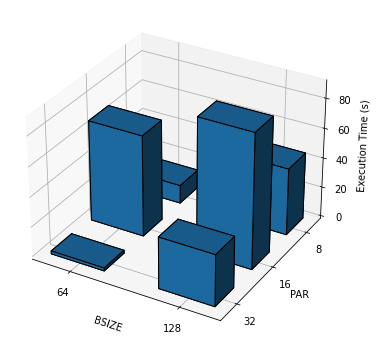

In [5]:
# Create 3D bar plot.

fig = plt.figure(figsize=(6,8))
ax1 = fig.add_subplot(111, projection='3d')

# Define lower coordinate of z axis.
floor = np.zeros(num_vals)

# Define width and depth of bars.
width = 0.5
depth = 0.5
dpar1 = np.ones(num_vals)*width
dpar2 = np.ones(num_vals)*depth

ax1.bar3d(par2_coords, par1_coords, floor, dpar2, dpar1, perf, 
          edgecolor='black')

ax1.set_xlabel(fields[PAR2_COL])
ax1.set_ylabel(fields[PAR1_COL])
ax1.set_zlabel(fields[PERF_COL])

plt.xticks(unique_par2_coords + width/2, 
           [par2_coord_map_inverse[coord] for coord in unique_par2_coords])
plt.yticks(unique_par1_coords + depth/2, 
           [par1_coord_map_inverse[coord] for coord in unique_par1_coords])

plt.show()

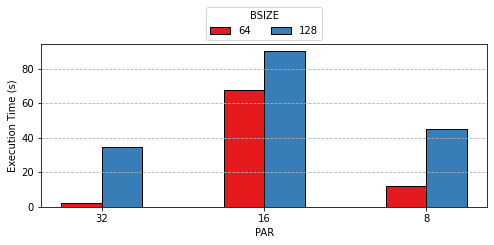

In [6]:
# Create 2D bar plot with color key for parameter 2.

fig = plt.figure(figsize=(8,4))
ax1 = fig.add_subplot(111)

# Set bar widths.
# num_bars_of_space indicates how many bars-worth of empty space should exist between bar clusters.
num_bars_of_space = 2
bar_width = 1 / (unique_par2_coords.size + num_bars_of_space)

# Use colormap to set bar colors. Use at least 8, otherwise colors may not look very good.
max_num_colors = max(8, unique_par2_coords.size)
colormap = plt.get_cmap('Set1', max_num_colors)

# Iterate through each value of parameter 2, and graph all performance values at this parameter 2 value.
# Allow the parameter 2 value to determine the color of the bars.
for par2_coord in unique_par2_coords:
    indices = np.where(par2_coords == par2_coord)[0]
    X = par1_coords[indices] + (par2_coord * bar_width)
    Y = perf[indices]
    ax1.bar(X, Y, width=bar_width, label=par2_coord_map_inverse[par2_coord],
           color=colormap(par2_coord/max_num_colors), edgecolor='black')
    
ax1.set_xlabel(fields[PAR1_COL])
ax1.set_ylabel(fields[PERF_COL])

# Shrink the current box's height to give space for the legend at the top.
box = ax1.get_position()
ax1.set_position([box.x0, box.y0,
                 box.width, box.height * 0.75])

# Put the legend above the box.
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.255), 
           ncol=unique_par2_coords.size, title=fields[PAR2_COL])

plt.xticks(unique_par1_coords + (unique_par2_coords.size - 1)*bar_width/2, 
           [par1_coord_map_inverse[coord] for coord in unique_par1_coords])

plt.grid(axis='y', linestyle='--')

plt.show()

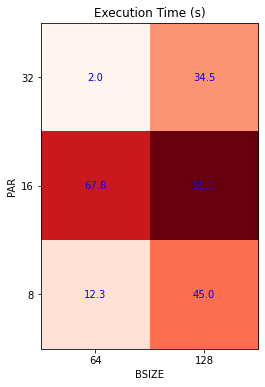

In [7]:
# Create heatmap.

# Create 2D array for heatmap values, where the rows correspond to different parameter 1 values, 
# and columns correspond to different parameter 2 values.
perf_heatmap = np.zeros((unique_par1_coords.size, unique_par2_coords.size))
for par1_coord in unique_par1_coords:
    par1_val = par1_coord_map_inverse[par1_coord]
    for par2_coord in unique_par2_coords:
        par2_val = par2_coord_map_inverse[par2_coord]
        perf_val = perf[np.where((par1 == par1_val) & (par2 == par2_val))]
        perf_heatmap[par1_coord][par2_coord] = perf_val
        
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(111)

im1 = ax1.imshow(perf_heatmap, cmap="Reds")

# Set tick and axes labels.
ax1.set_xticks(unique_par2_coords)
ax1.set_yticks(unique_par1_coords)
ax1.set_xticklabels([par2_coord_map_inverse[coord] for coord in unique_par2_coords])
ax1.set_yticklabels([par1_coord_map_inverse[coord] for coord in unique_par1_coords])
ax1.set_xlabel(fields[PAR2_COL])
ax1.set_ylabel(fields[PAR1_COL])

# Loop over data dimensions and create text annotations.
for par1_coord in unique_par1_coords:
    for par2_coord in unique_par2_coords:
        text = ax1.text(par2_coord, par1_coord, perf_heatmap[par1_coord, par2_coord],
                       ha="center", va="center", color="blue")
        
ax1.set_title(fields[PERF_COL])

plt.show()